# Query Pan-STARRS DR2 catalog using MAST API

The [new MAST interface](https://catalogs.mast.stsci.edu/) to the Pan-STARRS catalog supports queries to both the DR1 and DR2 PS1 catalogs.  It also has an associated [API](https://catalogs.mast.stsci.edu/docs/panstarrs.html), which is used in this script.

This script shows how to query the Pan-STARRS DR2 catalog using the PS1 search API.  The examples show how to do a simple cone search, how to manipulate the table of results, and how to get a light curve from the table of detections.

This notebook is available for [download](https://ps1images.stsci.edu/ps1_dr2_api.ipynb).

In [1]:
%matplotlib inline
from astropy.io import ascii
from astropy.table import Table

import sys
import re
import numpy as np
import pylab
import json
import requests

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib   

## Useful functions

Execute PS1 searches and resolve names using [MAST query](https://mast.stsci.edu/api/v0/MastApiTutorial.html).

In [2]:
def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)


def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{baseurl}/{release}/{table}.{format}".format(**locals())
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))


def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = "{baseurl}/{release}/{table}/metadata".format(**locals())
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data
    """
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


### Use metadata query to get information on available columns

This query works for any of the tables in the API (mean, stack, detection).

In [3]:
meta = ps1metadata("mean","dr2")
meta

name,type,description
str17,str6,str142
objName,STRING,IAU name for this object.
objAltName1,STRING,Alternate name for this object.
objAltName2,STRING,Altername name for this object.
objAltName3,STRING,Altername name for this object.
objID,NUMBER,Unique object identifier.
uniquePspsOBid,NUMBER,Unique internal PSPS object identifier.
ippObjID,NUMBER,IPP internal object identifier.
surveyID,NUMBER,Survey identifier. Details in the Survey table.
htmID,NUMBER,Hierarchical triangular mesh (Szalay 2007) index.


## Simple positional query

Search mean object table with nDetections > 1.

This searches the mean object catalog for objects within 50 arcsec of M87 (RA=187.706, Dec=12.391 in degrees). Note that the results are restricted to objects with `nDetections>1`, where `nDetections` is the total number of times the object was detected on the single-epoch images in any filter at any time.  Objects with `nDetections=1` tend to be  artifacts, so this is a quick way to eliminate most spurious objects from the catalog.

In [4]:
ra = 187.706
dec = 12.391
radius = 50.0/3600.0
constraints = {'nDetections.gt':1}

# strip blanks and weed out blank and commented-out values
columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag""".split(',')
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]
results = ps1cone(ra,dec,radius,release='dr2',columns=columns,verbose=True,**constraints)
# print first few lines
lines = results.split('\n')
print(len(lines),"rows in results -- first 5 rows:")
print('\n'.join(lines[:6]))

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?nDetections.gt=1&ra=187.706&dec=12.391&radius=0.013888888888888888&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%5D
47 rows in results -- first 5 rows:
objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,19.867399215698242,18.59269905090332,19.06920051574707,18.139400482177734,-999.0
122851877008084336,187.70080125,12.37828064,15,3,2,5,5,0,21.162900924682617,-999.0,18.75429916381836,18.438899993896484,-999.0
122851877018527082,187.70183167,12.38053514,5,2,2,1,0,0,20.314599990844727,-999.0,18.168699264526367,-999.0,-999.0
122851877049294726,187.70495239,12.37851452,7,2,2,2,1,0,19.03059959411621,18.453699111938477,18.576099395751953,-999.0,-999.0
122851877062673559,187.70624956,12.37754834,7,1,2,3,0,1,20.520999908447266

### Convert the results to an astropy table

The CSV results string is easily converted to an [astropy table](http://docs.astropy.org/en/stable/table/).  This table is easily manipulated to extract information on individual columns or rows.

In [5]:
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    try:
        tab[col].format = ".4f"
        tab[col][tab[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,19.8674,18.5927,19.0692,18.1394,nan
122851877008084336,187.70080125,12.37828064,15,3,2,5,5,0,21.1629,nan,18.7543,18.4389,nan
122851877018527082,187.70183167,12.38053514,5,2,2,1,0,0,20.3146,nan,18.1687,nan,nan
122851877049294726,187.70495239,12.37851452,7,2,2,2,1,0,19.0306,18.4537,18.5761,nan,nan
122851877062673559,187.70624956,12.37754834,7,1,2,3,0,1,20.5210,18.9063,18.9627,nan,18.1421
122851877090477761,187.70902824,12.38101615,29,6,7,11,5,0,19.7468,17.7461,17.4915,17.6221,nan
122851877096718451,187.70969564,12.38158628,2,1,0,1,0,0,20.5734,nan,nan,nan,nan
122851877109888891,187.71098809,12.38200012,2,0,0,2,0,0,nan,nan,nan,nan,nan
122851877115528846,187.71134341,12.38181909,2,1,1,0,0,0,23.3524,17.3302,nan,nan,nan


### Query for a single object by objID

It is possible to query the catalog directly on the object identifier without any RA/Dec restriction.  This might not be particularly useful when search for objects, but it is very useful when searching the detection table for time-series data.

In [6]:
results1 = ps1search(release='dr2',columns=columns,verbose=True,objid=122851876947049923)
tab1 = ascii.read(results1)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    try:
        tab1[col].format = ".4f"
        tab1[col][tab1[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
tab1

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?objid=122851876947049923&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%5D


objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,19.8674,18.5927,19.0692,18.1394,nan


### Search stack objects at same position

There is no need for the `nDetections` limit for stack objects, which can in fact have `nDetections = 0` for objects that are too faint to be detected on single-epoch images.  But we require `primaryDetection=1` in order to eliminate duplicate sources at the edges of the skycell regions used for processing.  (There is another column `bestDetection` that would be better suited for this test but is currently not correct in the database.)

In [7]:
sconstraints = {'primaryDetection':1}

scolumns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
    nStackDetections,primaryDetection,
    gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag""".split(',')
# strip blanks and weed out blank and commented-out values
scolumns = [x.strip() for x in scolumns]
scolumns = [x for x in scolumns if x and not x.startswith('#')]

sresults = ps1cone(ra,dec,radius,table="stack",release="dr2",columns=scolumns,verbose=True,**sconstraints)
stab = ascii.read(sresults)
for col in scolumns:
    try:
        stab[col]
    except KeyError:
        print(col,"not found")
# improve the format
for filter in 'grizy':
    col = filter+'PSFMag'
    try:
        stab[col].format = ".4f"
        stab[col][stab[col] == -999.0] = np.nan
    except KeyError:
        print("{} not found".format(col))
stab

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/stack.csv?primaryDetection=1&ra=187.706&dec=12.391&radius=0.013888888888888888&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CnStackDetections%2CprimaryDetection%2CgPSFMag%2CrPSFMag%2CiPSFMag%2CzPSFMag%2CyPSFMag%5D


objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,8,1,19.6062,18.6094,18.6439,18.5461,nan
122851877008084336,187.70080125,12.37828064,15,3,2,5,5,0,3,1,19.5519,nan,18.4844,18.4317,nan
122851877049294726,187.70495239,12.37851452,7,2,2,2,1,0,1,1,nan,18.2340,nan,nan,nan
122851877062673559,187.70624956,12.37754834,7,1,2,3,0,1,1,1,21.2941,nan,nan,18.3366,nan
122851877090477761,187.70902824,12.38101615,29,6,7,11,5,0,8,1,18.8032,nan,17.7515,17.7051,17.2640
122851877096718451,187.70969564,12.38158628,2,1,0,1,0,0,2,1,18.8283,nan,nan,nan,nan
122851877124637737,187.71246077,12.38100609,50,9,10,15,9,7,10,1,19.1700,18.0277,17.9962,17.8764,17.4738
122861876929948166,187.69304884,12.38978617,7,2,0,3,2,0,8,1,19.4459,18.5033,18.4054,18.3286,nan
122861876979515942,187.69789315,12.38779688,44,8,7,13,8,8,10,1,18.4712,17.4164,17.3963,17.3396,16.9031


### Explore the tables

Match the stack and mean tables and look at the subset of sources that are detected in both catalogs.  The commented-out lines show how to restrict the joined table to only stack detections and to only stack non-detections.

In [8]:
from astropy.table import join
jtab = join(stab,tab,join_type='outer')
jtab.sort('objID')
jtab_both = jtab[(jtab['primaryDetection']==1) & (jtab['nDetections']>1)]

#jtab[jtab['nStackDetections'].mask].show_in_notebook()
#jtab[~jtab['nStackDetections'].mask].show_in_notebook()
#jtab.show_in_notebook()
jtab_both.show_in_notebook()

idx,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,nStackDetections,primaryDetection,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
0,122851876947049923,187.69476028,12.382815,8,2,1,2,3,0,8,1,19.6062,18.6094,18.6439,18.5461,nan,19.8674,18.5927,19.0692,18.1394,nan
1,122851877008084336,187.70080125,12.37828064,15,3,2,5,5,0,3,1,19.5519,nan,18.4844,18.4317,nan,21.1629,nan,18.7543,18.4389,nan
2,122851877049294726,187.70495239,12.37851452,7,2,2,2,1,0,1,1,nan,18.2340,nan,nan,nan,19.0306,18.4537,18.5761,nan,nan
3,122851877062673559,187.70624956,12.37754834,7,1,2,3,0,1,1,1,21.2941,nan,nan,18.3366,nan,20.5210,18.9063,18.9627,nan,18.1421
4,122851877090477761,187.70902824,12.38101615,29,6,7,11,5,0,8,1,18.8032,nan,17.7515,17.7051,17.2640,19.7468,17.7461,17.4915,17.6221,nan
5,122851877096718451,187.70969564,12.38158628,2,1,0,1,0,0,2,1,18.8283,nan,nan,nan,nan,20.5734,nan,nan,nan,nan
6,122851877124637737,187.71246077,12.38100609,50,9,10,15,9,7,10,1,19.1700,18.0277,17.9962,17.8764,17.4738,19.3247,18.0296,17.7988,17.9304,17.5089
7,122861876929948166,187.69304884,12.38978617,7,2,0,3,2,0,8,1,19.4459,18.5033,18.4054,18.3286,nan,19.7578,nan,18.5519,19.2260,nan
8,122861876979515942,187.69789315,12.38779688,44,8,7,13,8,8,10,1,18.4712,17.4164,17.3963,17.3396,16.9031,18.2713,17.4948,17.2884,17.4338,17.1059
9,122861877059169881,187.70591961,12.39112604,54,10,10,14,8,12,10,1,15.5246,14.3670,14.4603,14.3573,14.0464,10.2950,10.7320,11.0760,11.3420,11.5570


### Plot RA & Dec positions of mean and stack objects

Note that `raMean` and `decMean` are defined for all objects, including stack-only objects.   For objects detected only on the stacked images, the `raStack` and `decStack` values are given in the `raMean` and `decMean` columns.  That makes it simple to analyze the positions without testing to see what positions are available.

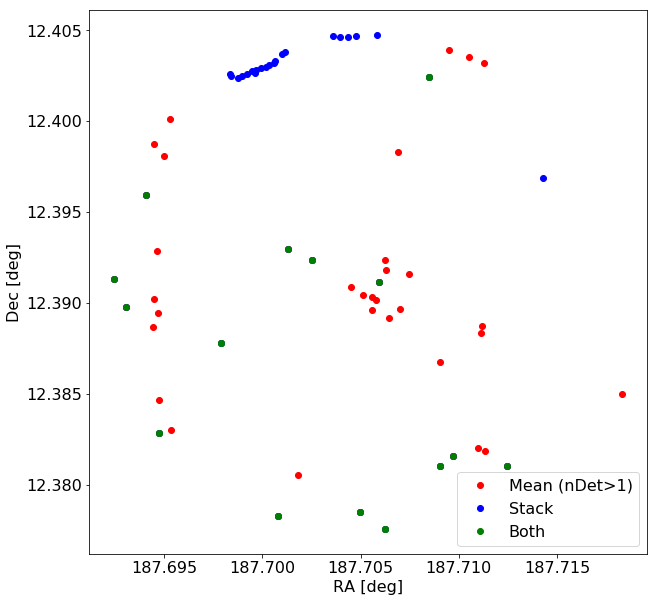

In [9]:
pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,10))
pylab.plot(tab['raMean'], tab['decMean'], 'ro', label='Mean (nDet>1)')
pylab.plot(stab['raMean'], stab['decMean'], 'bo', label='Stack')
pylab.plot(jtab_both['raMean'], jtab_both['decMean'], 'go', label='Both')

pylab.xlabel('RA [deg]')
pylab.ylabel('Dec [deg]')
pylab.legend(loc='best')

## Get DR2 light curve for RR Lyrae star KQ UMa

This time we start with the object name, use the MAST name resolver (which relies on Simbad and NED) to convert the name to RA and Dec, and then query the PS1 DR2 mean object catalog at that position.  A small search radius is used so only a single object is returned.

In [10]:
objname = 'KQ UMa'
ra, dec = resolve(objname)
radius = 1.0/3600.0 # radius = 1 arcsec

results = ps1cone(ra,dec,radius,release='dr2',columns=columns,**constraints)
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    tab[col].format = ".4f"
    tab[col][tab[col] == -999.0] = np.nan
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
190361393344112894,139.33444972,68.6350604,66,8,10,21,13,14,15.0402,14.5530,14.2109,14.2814,14.3041


### Get the detection information

Extract all the objects with the same object ID from the Detection table, which contains all the individual measurements for this source.

In [11]:
def addfilter(dtab):
    """Add filter name as column in detection table by translating filterID
    
    This modifies the table in place.  If the 'filter' column already exists,
    the table is returned unchanged.
    """
    if 'filter' not in dtab.colnames:
        # the filterID value goes from 1 to 5 for grizy
        id2filter = np.array(list('grizy'))
        dtab['filter'] = id2filter[(dtab['filterID']-1).data]
    return dtab

objid = tab['objID'][0]
dconstraints = {'objID': objid}
dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
            psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
# strip blanks and weed out blank and commented-out values
dcolumns = [x.strip() for x in dcolumns]
dcolumns = [x for x in dcolumns if x and not x.startswith('#')]

dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
dtab = addfilter(ascii.read(dresults))
dtab.sort('obsTime')
dtab

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str1
190361393344112894,115636667260000047,5,55257.3668569,139.33445713,68.63507615,0.005354930181056261,2.6245999833918177e-05,2.5283899307250977,2.4677300453186035,0.9989349842071533,0.005433760117739439,1.6695599697413854e-05,102760517,128,24119360,y
190361393344112894,115637788260000041,5,55257.3780646,139.33444929,68.63506405,0.005313179921358824,2.175470035581384e-05,1.8098100423812866,1.7773000001907349,0.999800980091095,0.005322880111634731,1.7123500583693385e-05,102760517,128,124815424,y
190361393344112894,118025265260000028,4,55281.2528285,139.33447243,68.63507592,0.005556920077651739,1.2427400179149117e-05,1.1078200340270996,0.9493029713630676,0.9975399971008301,0.005616980139166117,1.2113199773011729e-05,102760517,128,7374912,z
190361393344112894,118026233260000017,4,55281.2625151,139.3344753,68.63507505,0.006145799998193979,1.3183999726606999e-05,1.0866999626159668,0.9652569890022278,0.9555839896202087,0.006260519847273827,1.2802999663108494e-05,102760517,128,7374912,z
190361393344112894,142663796520000019,4,55527.6381469,139.33444657,68.63507265,0.005942150019109249,1.2578700079757255e-05,1.1702100038528442,1.1396000385284424,0.9973800182342529,0.0059954398311674595,1.2208300177007914e-05,102760517,128,7374912,z
190361393344112894,142665071520000011,4,55527.6508919,139.33444962,68.63506557,0.005690529942512512,1.2433300071279518e-05,1.1921099424362183,1.1337599754333496,0.9972649812698364,0.005855679977685213,1.2070199773006607e-05,102760517,128,7374912,z
190361393344112894,145454631520000040,5,55555.5464962,139.3344544,68.63505782,0.005188710056245327,2.3331000193138607e-05,1.792080044746399,1.558210015296936,0.9971089959144592,0.005270369816571474,1.846049963205587e-05,102760517,128,124815424,y
190361393344112894,145455366520000043,5,55555.5538486,139.33445034,68.63506318,0.0053047300316393375,2.412799949524924e-05,2.6756300926208496,2.5351500511169434,0.9975789785385132,0.005306419916450977,1.8608299797051586e-05,102760517,128,124815424,y
190361393344112894,153347716310000010,1,55634.477414,139.3345207,68.63503577,0.00826191995292902,1.1407400052121375e-05,1.881850004196167,1.7673399448394775,0.9929159879684448,0.008617050014436245,1.1423299838497769e-05,102760517,128,124782656,g


### Plot the light curves

The `psfFlux` values from the Detection table are converted from Janskys to AB magnitudes.  Measurements in the 5 different filters are plotted separately.

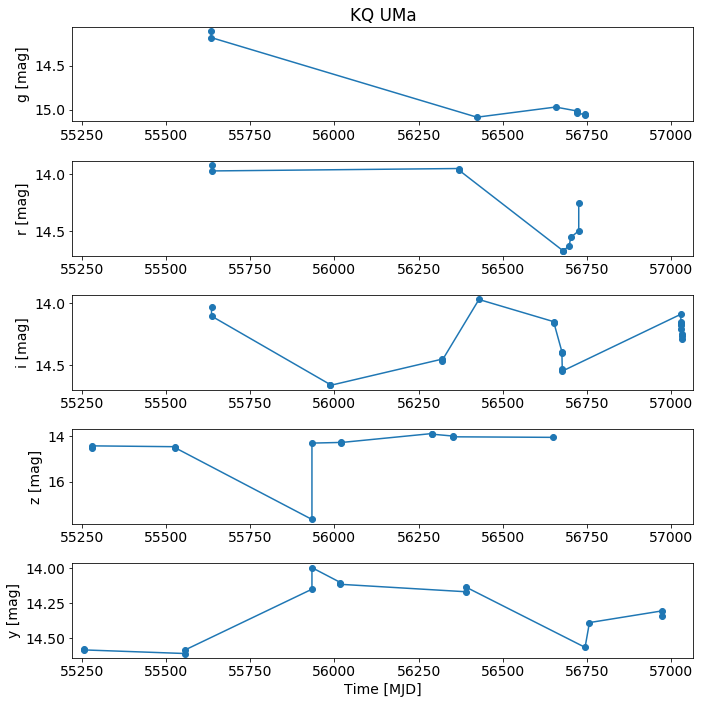

In [12]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    pylab.plot(t[w],mag[w],'-o')
    pylab.ylabel(filter+' [mag]')
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Plot differences from the mean magnitudes in the initial search.

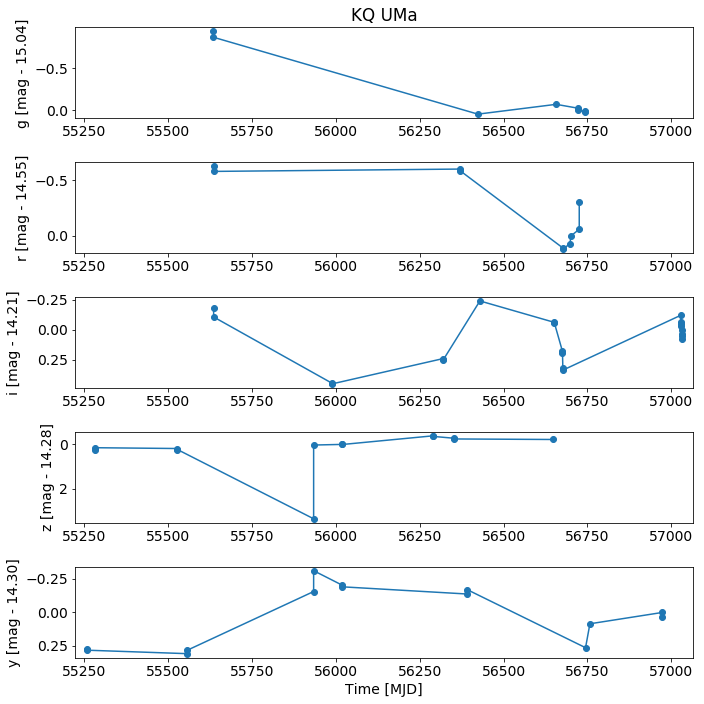

In [13]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)
    magmean = tab[filter+'MeanPSFMag'][0]
    pylab.plot(t[w],mag[w] - magmean,'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Identify bad data

There is one clearly bad $z$ magnitude with a very large difference.  Select the bad point and look at it in more detail.

Note that indexing a table (or numpy array) with a logical expression selects just the rows where that expression is true.

In [14]:
dtab[ (dtab['filter']=='z') & (np.abs(mag-tab['zMeanPSFMag'][0]) > 2) ]

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str1
190361393344112894,183252627520000234,4,55933.5264577,139.33488168,68.63532273,0.00031794499955140054,6.730079803674016e-06,1.075369954109192,1.0153000354766846,0.32298600673675537,0.00021321700478438288,2.3693899038335076e-06,102760453,128,32768,z


From examining this table, it looks like `psfQfPerfect` is bad.  This flag is the PSF-weighted fraction of unmasked pixels in the image (see the [documentation](https://outerspace.stsci.edu/x/IoOc) for more details). Values near unity indicate good data that is not significantly affected by bad pixels.

Check all the `psfQfPerfect` values for the $z$ filter to see if this value really is unusual.  The list of values below are sorted by magnitude.  The bad point is the only value with `psfQfPerfect` < 0.95.

In [15]:
w = np.where(dtab['filter']=='z')
zdtab = dtab[w]
zdtab['mag'] = mag[w]
zdtab['dmag'] = zdtab['mag'] - tab['zMeanPSFMag'][0]
ii = np.argsort(-np.abs(zdtab['dmag']))
zdtab = zdtab[ii]
zdtab['objID','obsTime','mag','dmag','psfQfPerfect']

objID,obsTime,mag,dmag,psfQfPerfect
int64,float64,float64,float64,float64
190361393344112894,55933.5264577,17.64412000237564,3.3627202755079644,0.32298600673675537
190361393344112894,56289.6159346,13.890659485398782,-0.39074024146889386,0.9978110194206238
190361393344112894,56289.6241112,13.91680636450095,-0.3645933623667261,0.9883689880371094
190361393344112894,56351.4168483,13.998972898415117,-0.28242682845255906,0.9992570281028748
190361393344112894,55281.2528285,14.537914623514524,0.25651489664684846,0.9975399971008301
190361393344112894,56351.424076,14.03250199848879,-0.24889772837888557,0.9991869926452637
190361393344112894,55527.6508919,14.512118217847153,0.23071849097947705,0.9972649812698364
190361393344112894,56648.5676019,14.05642973518955,-0.22496999167812604,0.9979820251464844
190361393344112894,55527.6381469,14.465140969832703,0.18374124296502714,0.9973800182342529


### Repeat the plot with bad psfQfPerfect values excluded

Do the plot again but exclude low psfQfPerfect values.

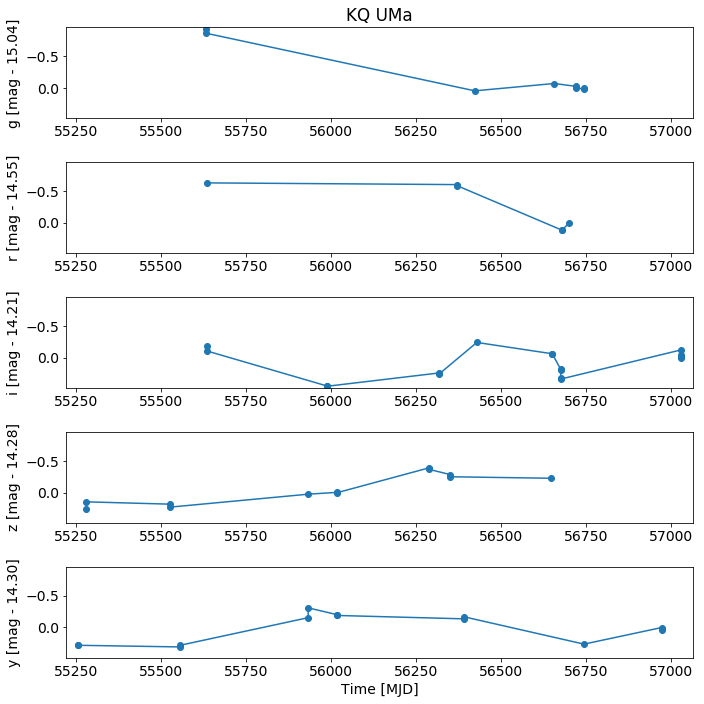

In [16]:
# convert flux in Jy to magnitudes
t = dtab['obsTime']
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
magmean = 0.0*mag
for filter in "grizy":
    magmean[dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dmag = mag - magmean
dmag1 = dmag[dtab['psfQfPerfect']>0.9]
# fix the x and y axis ranges
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
# flip axis direction for magnitude
ylim = np.array([dmag1.max(),dmag1.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where((dtab['filter']==filter) & (dtab['psfQfPerfect']>0.9))[0]
    pylab.plot(t[w],dmag[w],'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean[w[0]]))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Plot versus the periodic phase instead of epoch

Plot versus phase using known RR Lyr period from Simbad (table [J/AJ/132/1202/table4](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/AJ/132/1202/table4&-c=KQ%20UMa&-c.u=arcmin&-c.r=2&-c.eq=J2000&-c.geom=r&-out.max=50&-out.form=HTML%20Table&-oc.form=sexa)).

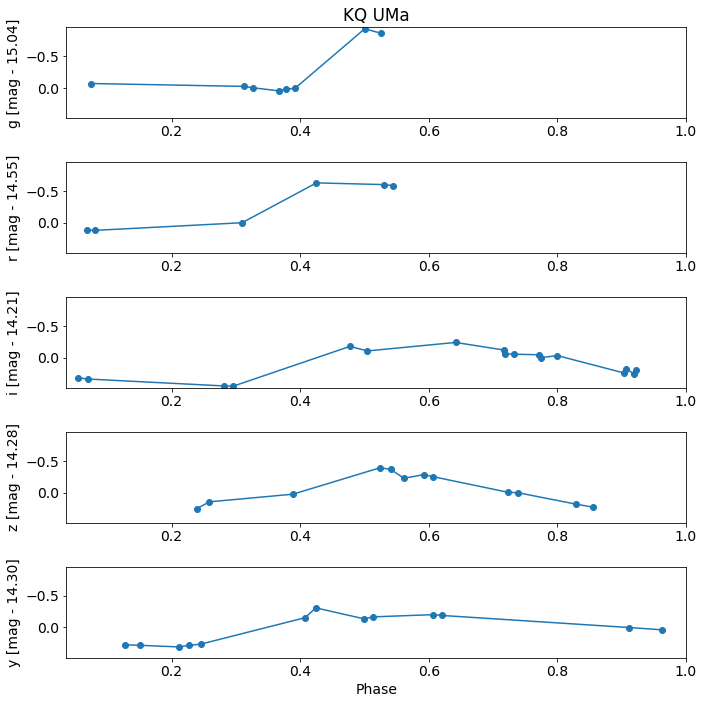

In [17]:
period = 0.48636
# convert flux in Jy to magnitudes
t = (dtab['obsTime'] % period) / period
mag = -2.5*np.log10(dtab['psfFlux']) + 8.90
magmean = 0.0*mag
for filter in "grizy":
    magmean[dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dmag = mag - magmean
dmag1 = dmag[dtab['psfQfPerfect']>0.9]
# fix the x and y axis ranges
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
# flip axis direction for magnitude
ylim = np.array([dmag1.max(),dmag1.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where((dtab['filter']==filter) & (dtab['psfQfPerfect']>0.9))[0]
    w = w[np.argsort(t[w])]
    pylab.plot(t[w],dmag[w],'-o')
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean[w[0]]))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Phase')
pylab.tight_layout()

## Repeat search using eclipsing binary KIC 2161623

From [Villanova Kepler Eclipsing Binaries](http://keplerebs.villanova.edu)

In [18]:
objname = 'KIC 2161623'
ra, dec = resolve(objname)
radius = 1.0/3600.0 # radius = 1 arcsec

results = ps1cone(ra,dec,radius,release='dr2',columns=columns,**constraints)
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    tab[col].format = ".4f"
    tab[col][tab[col] == -999.0] = np.nan
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
153102917444859851,291.74446451,37.5910001,67,10,16,12,15,14,14.5998,14.2821,14.1587,14.2004,14.0672


### Get the detection information

This time include the `psfQfPerfect` limit directly in the database query.

In [19]:
objid = tab['objID'][0]
dconstraints = {'objID': objid, 'psfQfPerfect.min': 0.9}
dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
            psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
# strip blanks and weed out blank and commented-out values
dcolumns = [x.strip() for x in dcolumns]
dcolumns = [x for x in dcolumns if x and not x.startswith('#')]

dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
dtab = addfilter(ascii.read(dresults))
dtab.sort('obsTime')

# add magnitude and difference from mean
dtab['magmean'] = 0.0
for filter in "grizy":
    dtab['magmean'][dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dtab['mag'] = -2.5*np.log10(dtab['psfFlux']) + 8.90
dtab['dmag'] = dtab['mag']-dtab['magmean']
dtab

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter,magmean,mag,dmag
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str1,float64,float64,float64
153102917444859851,90150443710000088,1,55002.5047803,291.74446391,37.5910006,0.005010080058127642,6.656870027654804e-06,1.9874399900436401,1.8121099472045898,0.9994210004806519,0.005174130201339722,7.312250090762973e-06,102760517,128,124815424,g,14.599800109863281,14.650388335768376,0.05058822590509493
153102917444859851,90151959710000087,1,55002.5199475,291.74446611,37.59100156,0.004873340018093586,6.488439794338774e-06,1.9848699569702148,1.7079299688339233,0.9992340207099915,0.005115420091897249,7.277139957295731e-06,102760517,128,124815424,g,14.599800109863281,14.680433215939235,0.08063310607595398
153102917444859851,91252543710000102,2,55013.5256677,291.74445985,37.59099454,0.007002430036664009,8.784800229477696e-06,1.9018700122833252,1.6868900060653687,0.9989619851112366,0.007235129829496145,9.829150258156005e-06,102760517,128,7374912,r,14.282099723815918,14.286878054116233,0.004778330300315048
153102917444859851,92647667550000182,5,55027.4768617,291.744466,37.59099285,0.008112230338156223,2.6664600227377377e-05,2.322920083999634,1.961549997329712,0.985031008720398,0.008413099683821201,2.082009996229317e-05,102760517,128,91228224,y,14.06719970703125,14.1271493162639,0.05994960923264969
153102917444859851,92648828550000192,5,55027.4884628,291.74446324,37.59100573,0.00829336978495121,3.020310032297857e-05,2.340280055999756,2.1763999462127686,0.9991379976272583,0.008452169597148895,2.102739927067887e-05,102760517,128,7342144,y,14.06719970703125,14.103172424635531,0.035972717604281
153102917444859851,92660989520000165,4,55027.6100795,291.74445806,37.59099457,0.006926320027559996,1.6556199625483714e-05,1.8979699611663818,1.6902999877929688,0.9989100098609924,0.007232369855046272,1.3667499842995312e-05,102760517,128,124782656,z,14.200400352478027,14.298743614845252,0.09834326236722468
153102917444859851,92662082520000201,4,55027.6210005,291.74446313,37.59099556,0.006681330036371946,1.744519977364689e-05,2.263400077819824,1.9174400568008423,0.9188709855079651,0.006415150128304958,1.287440045416588e-05,102760517,128,124782656,z,14.200400352478027,14.337842687389058,0.13744233491103053
153102917444859851,127445747460000143,3,55375.4577459,291.7444619,37.59100232,0.00789652019739151,9.349960237159394e-06,1.1853300333023071,1.100640058517456,0.9971380233764648,0.007905060425400734,9.893489732348826e-06,102760517,128,7374912,i,14.158699989318848,14.156410623675626,-0.002289365643221686
153102917444859851,127446972550000139,3,55375.4699934,291.74446324,37.59099754,0.007870550267398357,9.564520041749347e-06,1.177109956741333,1.0433599948883057,0.9975219964981079,0.008028780110180378,9.981689800042659e-06,102760517,128,108038208,i,14.158699989318848,14.15998725749483,0.0012872681759823479


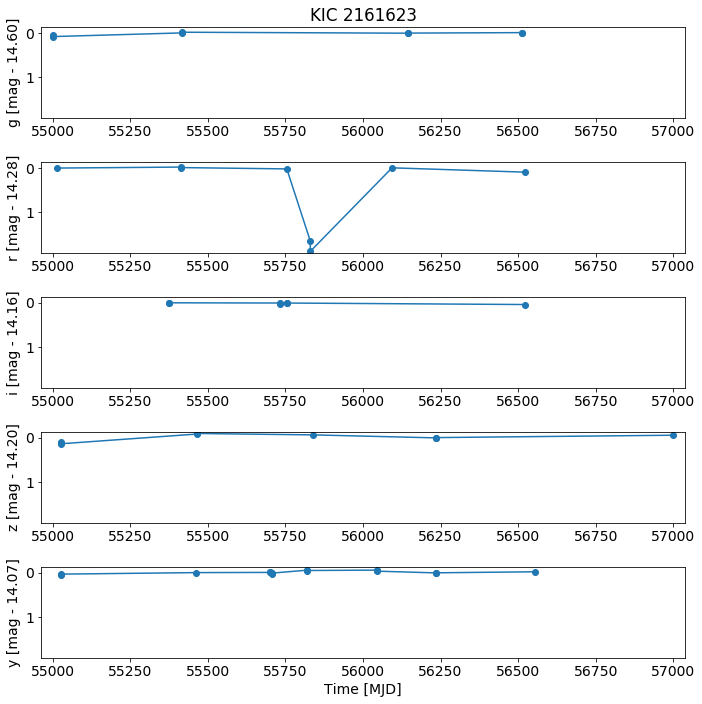

In [20]:
t = dtab['obsTime']
dmag = dtab['dmag']
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)[0]
    pylab.plot(t[w],dmag[w],'-o')
    magmean = dtab['magmean'][w[0]]
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

### Plot versus phase using known period

Eclipsing binaries basically vary by same amount in all filters since it is a geometrical effect, so combine the data into a single light curve.  Wrap using known period and plot versus phase.

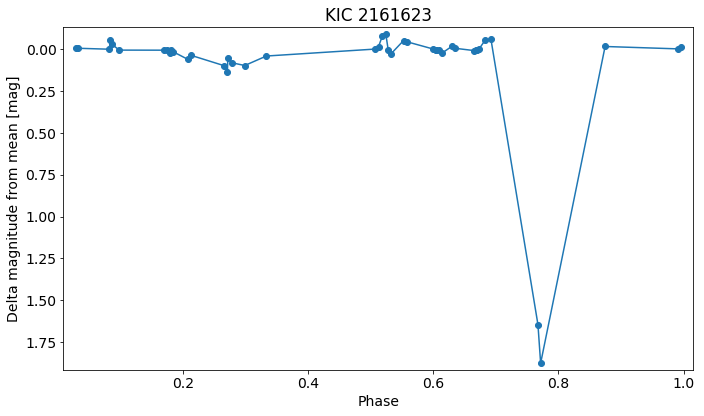

In [21]:
period = 2.2834698
bjd0 = 54999.599837
t = ((dtab['obsTime']-bjd0) % period) / period
dmag = dtab['dmag']
w = np.argsort(t)
t = t[w]
dmag = dmag[w]
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,6))
pylab.plot(t,dmag,'-o')
pylab.xlim(xlim)
pylab.ylim(ylim)
pylab.xlabel('Phase')
pylab.ylabel('Delta magnitude from mean [mag]')
pylab.title(objname)
pylab.tight_layout()

## Repeat search for another eclipsing binary KIC 8153568

In [22]:
objname = 'KIC 8153568'
ra, dec = resolve(objname)
radius = 1.0/3600.0 # radius = 1 arcsec

results = ps1cone(ra,dec,radius,release='dr2',columns=columns,**constraints)
tab = ascii.read(results)
# improve the format
for filter in 'grizy':
    col = filter+'MeanPSFMag'
    tab[col].format = ".4f"
    tab[col][tab[col] == -999.0] = np.nan
tab

objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag
int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
160802869044447231,286.90444402,44.00547369,88,16,15,31,10,16,15.1825,14.9899,14.8907,15.1999,14.8484


In [23]:
objid = tab['objID'][0]
dconstraints = {'objID': objid, 'psfQfPerfect.min': 0.9}
dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
            psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
# strip blanks and weed out blank and commented-out values
dcolumns = [x.strip() for x in dcolumns]
dcolumns = [x for x in dcolumns if x and not x.startswith('#')]

dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
dtab = addfilter(ascii.read(dresults))
dtab.sort('obsTime')

# add magnitude and difference from mean
dtab['magmean'] = 0.0
for filter in "grizy":
    dtab['magmean'][dtab['filter']==filter] = tab[filter+'MeanPSFMag'][0]
dtab['mag'] = -2.5*np.log10(dtab['psfFlux']) + 8.90
dtab['dmag'] = dtab['mag']-dtab['magmean']
dtab

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter,magmean,mag,dmag
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str1,float64,float64,float64
160802869044447231,91336429430000113,1,55014.3646518,286.90443374,44.00547575,0.003108999924734235,5.980649802950211e-06,1.7799999713897705,1.2381099462509155,0.9983350038528442,0.003124469891190529,5.692909780918853e-06,102760517,128,7374912,g,15.182499885559082,15.168448221176604,-0.01405166438247818
160802869044447231,91337480430000116,1,55014.3751566,286.90443894,44.00547502,0.003130560042336583,6.001439942338038e-06,1.6693899631500244,1.3277299404144287,0.9981970191001892,0.0031561299692839384,5.713579867006047e-06,102760517,128,124815424,g,15.182499885559082,15.160944905703076,-0.021554979856006184
160802869044447231,91338674430000149,2,55014.3869718,286.90444469,44.00548294,0.0038836700841784477,7.313420155696804e-06,1.8586900234222412,1.3646399974822998,0.9976969957351685,0.0038568999152630568,7.132980044843862e-06,102760517,128,7374912,r,14.989899635314941,14.926894175737598,-0.06300545957734371
160802869044447231,91339651330000132,2,55014.3967402,286.90445109,44.00547935,0.0037666400894522667,7.475080110452836e-06,1.5446300506591797,1.4460400342941284,0.9989830255508423,0.003935160115361214,7.260589882207569e-06,102760517,128,7342144,r,14.989899635314941,14.960114688961145,-0.02978494635379647
160802869044447231,91952738340000243,3,55020.5277331,286.90445036,44.00548294,0.001646470045670867,4.894850007985951e-06,1.3253799676895142,1.255769968032837,0.9769359827041626,0.0016092100413516164,3.8023099477868527e-06,102760517,128,124782656,i,14.890700340270996,15.85861541506495,0.9679150747939538
160802869044447231,91953928340000228,3,55020.5396333,286.90444716,44.00548808,0.0018249499844387174,5.4300599003909156e-06,1.6741000413894653,1.568869948387146,0.9812610149383545,0.0018035799730569124,3.995270162704401e-06,102760517,128,124782656,i,14.890700340270996,15.74687258388168,0.8561722436106844
160802869044447231,126057565120000092,1,55361.57592,286.90445317,44.00547451,0.003095729975029826,6.723119895468699e-06,1.7497999668121338,1.6242200136184692,0.9988260269165039,0.0031004499178379774,6.6938700911123306e-06,102760517,128,7374912,g,15.182499885559082,15.173092319156346,-0.009407566402735767
160802869044447231,126058741130000111,1,55361.587678,286.90445157,44.00548065,0.003028149949386716,6.5775197981565725e-06,1.6283899545669556,1.5257899761199951,0.9983869791030884,0.0031061999034136534,6.764249974366976e-06,102760517,128,7374912,g,15.182499885559082,15.197056557590734,0.01455667203165234
160802869044447231,126352519210000114,2,55364.5254296,286.90444653,44.00547878,0.003677440108731389,6.877689884277061e-06,1.0042699575424194,0.9495239853858948,0.9694520235061646,0.0037140899803489447,7.080509931256529e-06,102760517,128,7342144,r,14.989899635314941,14.986135978798345,-0.003763656516596825


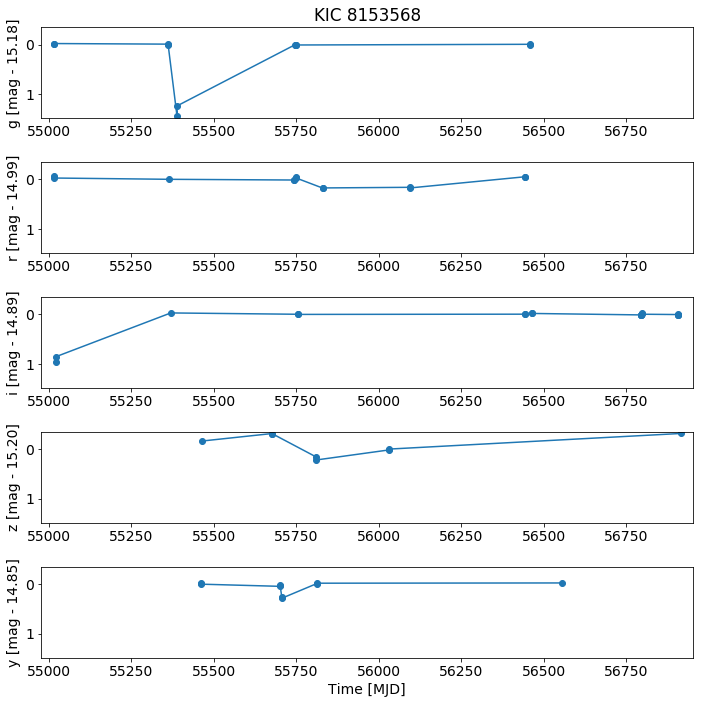

In [24]:
t = dtab['obsTime']
dmag = dtab['dmag']
xlim = np.array([t.min(),t.max()])
xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(10,10))
for i, filter in enumerate("grizy"):
    pylab.subplot(511+i)
    w = np.where(dtab['filter']==filter)[0]
    pylab.plot(t[w],dmag[w],'-o')
    magmean = dtab['magmean'][w[0]]
    pylab.ylabel('{} [mag - {:.2f}]'.format(filter,magmean))
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    if i==0:
        pylab.title(objname)
pylab.xlabel('Time [MJD]')
pylab.tight_layout()

Eclipsing binaries basically vary by same amount in all filters since it is a geometrical effect, so combine the data into a single light curve.

Wrap using known period and plot versus phase.  Plot two periods of the light curve this time.

This nice light curve appears to show a secondary eclipse.

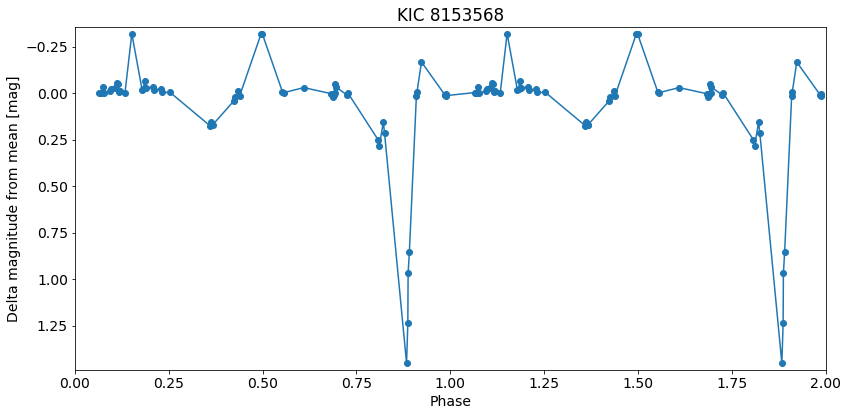

In [25]:
period = 3.6071431
bjd0 = 54999.289794
t = ((dtab['obsTime']-bjd0) % period) / period
dmag = dtab['dmag']
w = np.argsort(t)
# extend to two periods
nw = len(w)
w = np.append(w,w)
t = t[w]
# add one to second period
t[-nw:] += 1
dmag = dmag[w]
xlim = [0,2.0]
ylim = np.array([dmag.max(),dmag.min()])
ylim = ylim + np.array([-1,1])*0.02*(ylim[1]-ylim[0])

pylab.rcParams.update({'font.size': 14})
pylab.figure(1,(12,6))
pylab.plot(t,dmag,'-o')
pylab.xlim(xlim)
pylab.ylim(ylim)
pylab.xlabel('Phase')
pylab.ylabel('Delta magnitude from mean [mag]')
pylab.title(objname)
pylab.tight_layout()